# Monte Carlo Simulation

We aim to simulate samples of star-disk systems in which some of them are perfectly aligned while others are not. We do this by 1) sampling many thousands of these systems in their 3D space, 2) projecting these into an observer's point of view, and 3) adding uncertainties on both disk and stellar inclinations based on observations.

This code is build in collaboration with Siu, Wing-Yu; and it is largely based on C. Davies+ 2019, and Yen et al. (2024) papers.


For how to choose the distrbution of angles please refer to this article.
https://mathworld.wolfram.com/SpherePointPicking.html




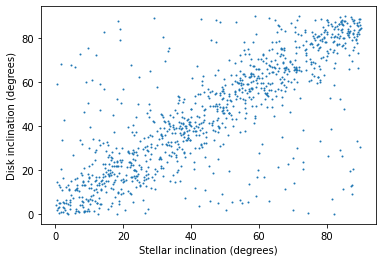

-0.3478277628250259
7.901094514205199


In [104]:
from scipy.stats import skewnorm
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
# np.random.seed(42)




def generate_distribution_true_angles(sample_size):
    '''
    We use theta is the azimuthal angle starting at zero from the X axis.
    and phi as the polar angle starting at zero from the zenith (Z axis)
    
    It then uses geometry to calculate the inclination angle measured from 
    an observer looking at the system through the X axis.
    In thi case the inclination value (alpha) is defined in the same direction as phi.
    zero to be aligned with the z axis and increasing and pole-on at 90 degrees. 
    tan(alpha) = X/Z
    '''
    theta_angle = np.random.uniform(low=0, high=1, size=sample_size)*2*np.pi
    phi_angle = np.arccos(2*np.random.uniform(low=0, high=1, size=sample_size)-1)
    
    inclination = np.arctan(np.tan(phi_angle)*np.cos(theta_angle))
    
    return inclination*180/np.pi


def modulate_distribution(array,mod):
    """
    When adding uncertainties after projections, it happens that
    some of the inclination values can get values <-90 or > 90 degrees
    This could be avoided if we either knew the real uncertainty in theta or phi
    angles (but we don't).
    We thus need to modulate the values outside of this range.
    If a value is >90
    """
    new_array = np.empty_like(array)
    for jj in range(len(array)):
        if array[jj] > mod:
            new_array[jj] = mod - (array[jj] - mod) 
        elif array[jj] < 0:
            new_array[jj] = np.abs(array[jj])
        else:
            new_array[jj] = array[jj]
            
    return new_array

def simulated_distributions(sample_size,alignment_fraction):
    """
    Define how many sky-projected rotation axis we need
    The total number is defined by sample_size.
    The fraction of those that are perfectly aligned will be defined
    by the parameter alignment_fraction.
    """
    # Determine number of aligned systems
    n_aligned = int(sample_size * alignment_fraction) 

    # Simulate inclinations for aligned systems
    stellar_inc_aligned = generate_distribution_true_angles(n_aligned)
    disk_inc_aligned = np.copy(stellar_inc_aligned)
    
    
    # Simulate inclinations for randomly oriented systems
    stellar_inc_random = generate_distribution_true_angles(sample_size - n_aligned)
    disk_inc_random = generate_distribution_true_angles(sample_size - n_aligned)
    
    # Combine inclinations for aligned and randomly oriented systems
    inclinations_stellar = np.concatenate((stellar_inc_aligned, stellar_inc_random))
    inclinations_disc = np.concatenate((disk_inc_aligned, disk_inc_random))
    
    
    return np.abs(inclinations_stellar), np.abs(inclinations_disc)


def uncertain_distributions(true_inclinations_stellar,true_inclinations_disc):
    '''
    Here we add the uncertainty based on the observatiosn of disks
    and stars. Currently, the uncertainties are taken from normal distributions
    however, we need to check the real distribution of uncertainties and mimic those.
    '''
    
    uncert_inclinations_stellar=np.empty(len(true_inclinations_stellar), dtype=float)
    uncer_inclinations_disc=np.empty(len(true_inclinations_disc), dtype=float)
    
    for ii, (true_inclinations_stellar,true_inclinations_disc) in enumerate(zip(true_inclinations_stellar,true_inclinations_disc)):
    
        uncert_inclinations_stellar[ii] = np.random.normal(loc = true_inclinations_stellar, scale= 8.0)
        uncer_inclinations_disc[ii] =  np.random.normal(loc = true_inclinations_disc, scale = 2.0) 
     
    return uncert_inclinations_stellar, uncer_inclinations_disc


def plot_histogram_distrubions(stellar,disk,nbins):

    fig, ax = plt.subplots()
    
    n,bins,patches=ax.hist([stellar,disk],bins=nbins,ec='k',rwidth=0.9)
    ax.set_ylabel('Numb. of sources',fontsize=14)
    ax.set_xlabel('obliquity',fontsize=14)

    plt.show()
    
def plot_distribution_comparison(*argv):
    """
    scatter plot the inclinations of different disk and stellar distributions
    """
    fig, ax = plt.subplots()

    for arg in argv:    
        ax.scatter(arg[0],arg[1], s=1)

    plt.xlabel('Stellar inclination (degrees)')
    plt.ylabel('Disk inclination (degrees)')
    plt.show()


if __name__ == "__main__":
    
    # Set sample size
    sample_size = 1000
    alignment_fraction = 0.8
    true_inclinations_stellar, true_inclinations_disc = simulated_distributions(sample_size,alignment_fraction)
    uncert_incl_stellar, uncert_incl_disk = uncertain_distributions(true_inclinations_stellar, true_inclinations_disc)
    
    mod_disk = modulate_distribution(uncert_incl_disk,mod=90)
    mod_star = modulate_distribution(uncert_incl_stellar,mod=90)

    plot_distribution_comparison([mod_star, mod_disk],
                                )
    
    diff= true_inclinations_stellar - uncert_incl_stellar
    print(np.median(diff))
    print(np.std(diff))
    
    
